In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import os
import glob
from astropy.io import fits

splpath = '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data'

In [2]:
pathlist = glob.glob(splpath+'/20260131*')
pathlist += glob.glob(splpath+'/20260201*')
pathlist += glob.glob(splpath+'/20260202*')
print(pathlist)

['/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_093212', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_193338', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_114551', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_211055', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_093856', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_174857', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_092625', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_123935', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_094013', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_122221', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_161141', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_225154', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_135116', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_094052', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260131_143807', '/mnt/m4storage/Data/M4Data/OPTData/SPL/Data/20260201_

/tmp/ipykernel_899589/4038745942.py:42: RankWarning: Polyfit may be poorly conditioned
  p0 = np.polyfit(texp[texp>=1e-1],img_mean[texp>=1e-1],1)


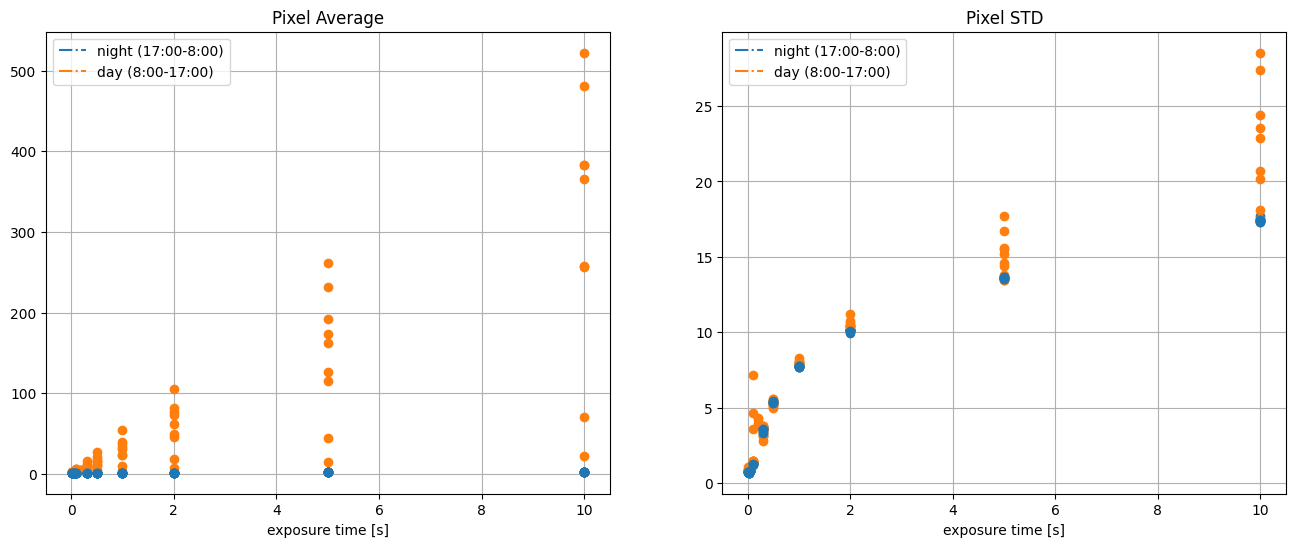

In [ ]:
# tnlist = ['20260131_123935','20260201_211755']
plt.figure(figsize=(16,6))

N=len(pathlist)

tnday = np.zeros(N)
tnhours = np.zeros(N)+np.nan
intercepts = np.zeros(N)+np.nan
coeffs = np.zeros(N)+np.nan

for k,fpath in enumerate(pathlist):
    # tnpath = os.path.join(splpath,tnpath)
    filelist = glob.glob(os.path.join(fpath,'ccd*'))
    img_mean = []
    img_std = []
    texp = []
    for ccdfile in filelist:
        hdu = fits.open(ccdfile)
        img = hdu[0].data
        hdr = hdu[0].header
        img_row_sum = np.sum(img,axis=0)
        null_rows = np.sum(img_row_sum == 0)
        if null_rows >= 3:
            print(f'Found {null_rows:1.0f} rows full of zeros, image might be corrupted')
        texp.append(hdr['EXPTIME'])
        img_mean.append(np.mean(img))
        img_std.append(np.std(img))
        # hist, bins = np.histogram(img.flatten(), bins = np.arange(0,1000,2,dtype=int).tolist()) 
        # plt.figure()
        # plt.hist(img.flatten(),bins)
    ids = np.argsort(texp)
    texp = np.array(texp)[ids]
    img_mean = np.array(img_mean)[ids]
    img_std = np.array(img_std)[ids]
    tn = fpath.split('/')[-1]
    tntime = tn.split('_')[-1]
    tnhour = np.floor(float(tntime)/1e+4)
    tnhour += (float(tntime)/1e+4-tnhour)*100/60
    tnday[k] = float(tn.split('_')[-2][-2:])
    # if len(texp>=1e-1) >= 4:
    #     tnhours[k] = tnhour
    #     p0 = np.polyfit(texp[texp>=1e-1],img_mean[texp>=1e-1],1)
    #     coeffs[k] = p0[0]
    #     intercepts[k] = p0[1]
    if len(texp) >= 4:
        tnhours[k] = tnhour
        p = np.polyfit(texp,img_mean,1)
        coeffs[k] = p[0]
        intercepts[k] = p[1]
    
    # Plot
    isNight = False
    dawn = 8
    dusk = 17
    if tnhour < dawn or tnhour > dusk:
        isNight = True
    plt.subplot(1,2,1)
    # plt.plot(texp,img_mean,'o',label=tn)
    if isNight:
        plt.plot(texp,img_mean,'o',color='C0')
    else:
        plt.plot(texp,img_mean,'o',color='C1')
    # plt.legend()
    plt.title('Pixel Average')
    plt.subplot(1,2,2)
    # plt.plot(texp,img_std,'o',label=tn)
    if isNight:
        plt.plot(texp,img_std,'o',color='C0')
    else:
        plt.plot(texp,img_std,'o',color='C1')
    # plt.legend()
    plt.title('Pixel STD')
    
for j in range(2):
    plt.subplot(1,2,1+j)
    night_proxy = mlines.Line2D([], [], color='C0', linestyle='dashdot', label=f'night ({dusk:1.0f}:00-{dawn:1.0f}:00)')
    day_proxy = mlines.Line2D([], [], color='C1', linestyle='dashdot', label=f'day ({dawn:1.0f}:00-{dusk:1.0f}:00)')
    plt.legend(handles=[night_proxy, day_proxy], loc='upper left')
    plt.grid()
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('exposure time [s]')

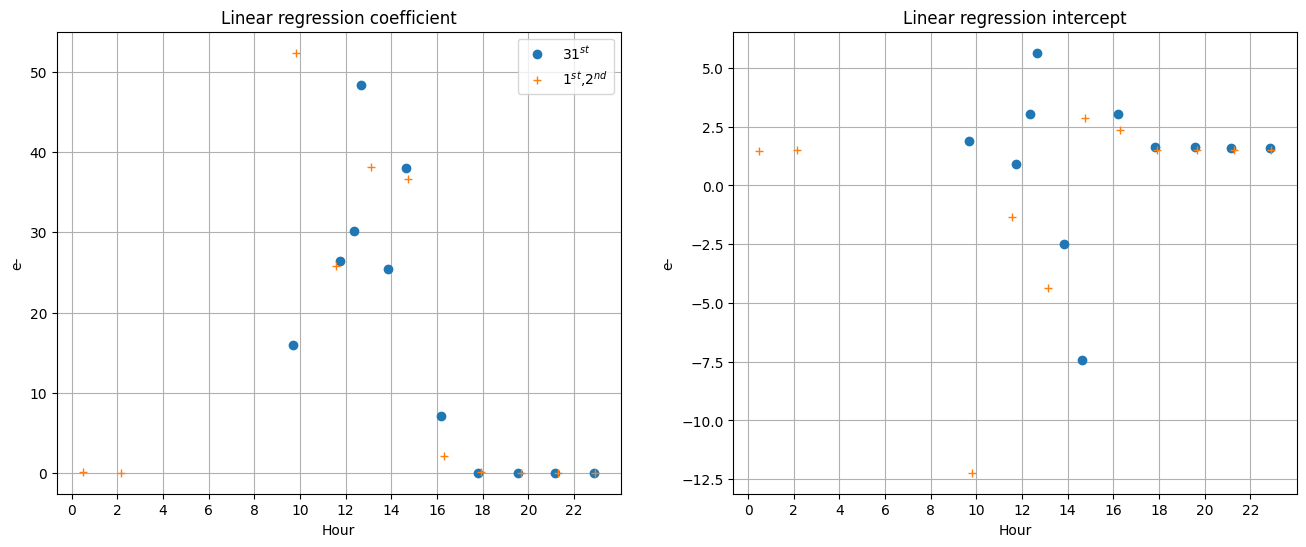

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(tnhours[tnday==31],coeffs[tnday==31],'o',label=r'$31^{st}$')
plt.plot(tnhours[tnday!=31],coeffs[tnday!=31],'+',label=r'$1^{st}$,$2^{nd}$')
plt.xticks(np.arange(0,24,2))
plt.legend()
plt.ylabel('[e-/s]')
plt.xlabel('Hour')
plt.title('Linear regression coefficient')
plt.grid()
plt.subplot(1,2,2)
plt.plot(tnhours[tnday==31],intercepts[tnday==31],'o',label=r'$31^{st}$')
plt.plot(tnhours[tnday!=31],intercepts[tnday!=31],'+',label=r'$1^{st}$,$2^{nd}$')
plt.ylabel('[e-]')
plt.xlabel('Hour')
plt.title('Linear regression intercept')
plt.xticks(np.arange(0,24,2))
plt.grid()

1.6536422 1.45 0.7219703 11
43.82 6.5 1.31 1.33 1.3811998245239259


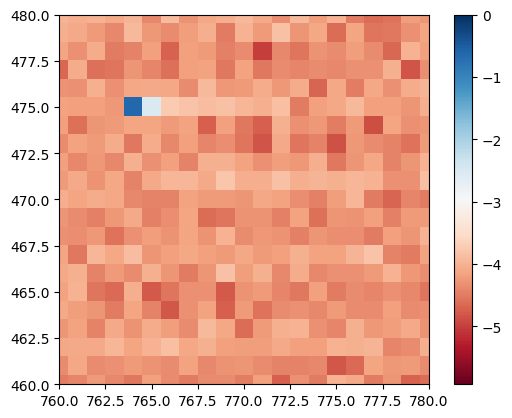

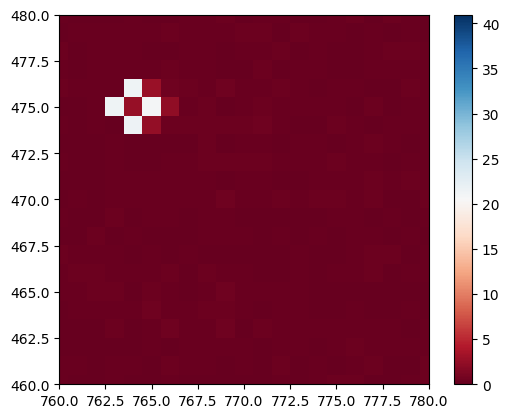

In [ ]:
gradX,gradY = np.gradient(img)
grad = np.sqrt(gradX**2+gradY**2)

plt.figure()
plt.imshow(np.log(img/np.max(img)),origin='lower',cmap='RdBu') #
plt.colorbar()
plt.xlim([760,780])
plt.ylim([460,480])

plt.figure()
plt.imshow(grad,origin='lower',cmap='RdBu')
plt.colorbar()
plt.xlim([760,780])
plt.ylim([460,480])

print(np.mean(img),np.median(img),np.std(img),np.sum(img>(np.mean(img)+10*np.std(img))))

print(img[475,764],img[475,765],img[474,764],img[474,765],np.mean(img[475-2:475+3,764-2:764+3]))